In [0]:
import numpy as np
%matplotlib inline
# 我們會使用到一些內建的資料庫, MAC需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from keras.datasets import fashion_mnist
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [0]:
labels = ['t-shirt', 'trouser', 
          'pullover', 'dress', 
          'coat', 'sandal', 
          'shirt', 'sneaker', 
          'bag', 'ankle boots']

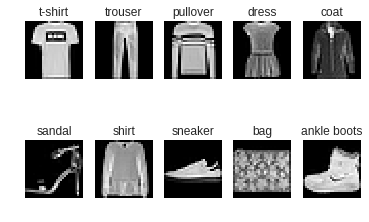

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
samples = {}
for (idx, label) in enumerate(y_train):
    if not label in samples:
        samples[label] = x_train[idx]
    if len(samples) == 10:
        break 
for key in sorted(samples):
    plt.subplot(2, 5, key + 1)
    plt.title(labels[key])
    plt.axis('off')
    plt.imshow(samples[key], cmap='gray')

In [0]:
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
x_train_shaped = (x_train - 127.5)/127.5
x_test_shaped = (x_test - 127.5)/127.5
# 不一樣!!要記得把標籤拿出來
y_train = y_train.reshape(-1, 1)

In [1]:
img_shape = (28, 28)
random_dim = 100

In [3]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization

generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, 
                    activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
generator.add(Reshape(img_shape))
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [ ]:
noise = Input(shape=(random_dim,))
label = Input(shape=(1,), dtype='int32')
label_embedding = Flatten()(Embedding(input_dim = 10, output_dim = random_dim)(label))

model_input = multiply([noise, label_embedding])
img = generator(model_input)

cgenerator = Model([noise, label], img)

cgenerator.compile(loss='binary_crossentropy', optimizer="adam")
cgenerator.summary()

In [4]:
discriminator = Sequential()
discriminator.add(Dense(512, input_dim=784,
                        activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(128, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total para

In [6]:
img = Input(shape=img_shape)
label = Input(shape=(1,), dtype='int32')
label_embedding = Flatten()(Embedding(10, 784)(label))
flat_img = Flatten()(img)
model_input = multiply([flat_img, label_embedding])
validity = discriminator(model_input)
cdiscriminator = Model([img, label], validity)
cdiscriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 784)       7840        input_4[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_3 

組合網路以訓練創作家

In [10]:
cdiscriminator.trainable = False
cgan_input = Input(shape=(random_dim,))
cgan_label = Input(shape=(1, ))
x = cgenerator([cgan_input, cgan_label])
cgan_output = cdiscriminator([x, cgan_label])
cgan = Model(inputs=[cgan_input, cgan_label], outputs=cgan_output)
cgan.compile(loss='binary_crossentropy', optimizer="adam")
cgan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28)       563704      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            574113      model_1[1][0]                    
          

In [15]:
batch_size = 200
epoch_count = 100

for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]
        labels = y_train[idx]
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟0:讓創作家製造出fake image
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = cgenerator.predict([noise, labels])

        # 步驟1:讓鑑賞家鑑賞對的image
        d_loss_real = cdiscriminator.train_on_batch([imgs, labels], valid)
        # 步驟2:讓鑑賞家鑑賞錯的image
        d_loss_fake = cdiscriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟3:訓練創作家的創作能力
        g_loss = cgan.train_on_batch([noise, labels], valid)

    if (epoch + 1) % 10 == 0:
        dash = "-" * 15
        print(dash, "epoch", epoch + 1, dash)
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)



--------------- epoch 10 ---------------
Discriminator loss: 0.4073936343193054
Generator loss: 1.485163
--------------- epoch 20 ---------------
Discriminator loss: 0.45828431844711304
Generator loss: 1.3055634
--------------- epoch 30 ---------------
Discriminator loss: 0.492333322763443
Generator loss: 1.3747383
--------------- epoch 40 ---------------
Discriminator loss: 0.43461155891418457
Generator loss: 1.5247307
--------------- epoch 50 ---------------
Discriminator loss: 0.4428834915161133
Generator loss: 1.3319385
--------------- epoch 60 ---------------
Discriminator loss: 0.44391652941703796
Generator loss: 1.3759596
--------------- epoch 70 ---------------
Discriminator loss: 0.4795100688934326
Generator loss: 1.403327
--------------- epoch 80 ---------------
Discriminator loss: 0.3963097333908081
Generator loss: 1.4492657
--------------- epoch 90 ---------------
Discriminator loss: 0.46034497022628784
Generator loss: 1.3583496
--------------- epoch 100 ---------------
Dis

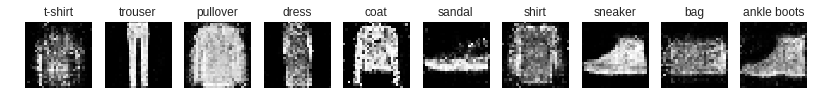

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
noise = np.random.normal(0, 1, (10, random_dim))
sampled_labels = np.arange(0, 10).reshape(-1, 1)

gen_imgs = cgenerator.predict([noise, sampled_labels])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs = gen_imgs.reshape(10, 28, 28)
plt.figure(figsize = (14, 4))

labels = ['t-shirt', 'trouser', 
          'pullover', 'dress', 
          'coat', 'sandal', 
          'shirt', 'sneaker', 
          'bag', 'ankle boots']

for i in range(0, 10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.title(labels[i])
    plt.imshow(gen_imgs[i], cmap='gray')